# Tarea 2. NN with LMS, Problema 1

## Fundamentos de inteligencia computacional
## por: Juan Pablo Arango A. & Simón Zapata Caro

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pydoc import help  # can type in the python console `help(name of function)` to get the documentation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from IPython.display import display, HTML
from pandas.tools.plotting import scatter_matrix
from matplotlib.artist import setp
import time

plt.rcParams['figure.figsize'] = (10,16)

In [2]:
df1     = pd.io.excel.read_excel("DatosPunto1.xlsx", sheetname=0)
classes = df1.iloc[:,-2].copy()
df1 = df1.iloc[:,0:-2].copy()
#normalización min-max
df1 = (df1-np.min(df1, axis = 0))/(np.max(df1, axis = 0)-np.min(df1, axis = 0))

y = np.array(classes)
X = np.array(df1)

In [3]:
X_original = X

Nsamples = X.shape[0]
Ntrain   = int(0.7*Nsamples)
Nval     = int(0.15*Nsamples)
Ntest    = Nsamples-Ntrain-Nval

X_test = X[(Nsamples-Ntest):Nsamples,:]
y_test = y[(Nsamples-Ntest):Nsamples  ]

Xv = X[0:(Nsamples-Ntest),:]
yv = y[0:(Nsamples-Ntest)  ]

In [4]:
def derivating(fx):
    difcoefs = [1,-1]
    return np.convolve(fx,difcoefs,mode='same')

def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

def clearList(L): #arroja una lista de L elementos vacios, no sabia de qué otra forma hacerla
    listica = []
    for i in range(0,L):
        listica.append([]);
    return listica

def LMS_training(X,y,iteraciones=500,alpha=0.1,de_min=0.01):
    
    ##falta mirar como imprimir Error en tiempo real
    
    w_          = np.random.rand(X.shape[1] + 1,)
    n           = X.shape[0]
    nf          = X.shape[1]
    sw          = 0
    j           = 0
    index       = []
    error_array = []
    

    while j < iteraciones and sw == 0:
        for i in range(0,n):
            g  = np.dot(w_,np.insert(X[i,:],0,1).T)
            e  = g - y[i]
            w_ = w_ - alpha*e*np.insert(X[i,:],0,1)
        predicted = []
        for i in range(0,n):
            predicted.append(Predict(X[i,:],w_))
        g = (y-predicted)
        E = 0.5*np.sum(g*g.T)/y.shape #queda la duda
        
        index.append(j)
        error_array.append(E[0])
        d_error_array = derivating(error_array)
        
        if np.abs(d_error_array[len(d_error_array)-1]) < de_min:
            sw = 1
        
        j = j + 1
    print('Función de error: '+str(E[0])+' iterando ' +str(j)+' veces, con alpha: '+str(alpha))
    
    return [w_,predicted]

def Predict(X,w_): 
    return np.dot(w_,np.insert(X,0,1).T)


### Entrenamiento de la red neuronal usando validación bootstraping para $\alpha = logspace(10^{-5}, 0.5=10^{-0.30102}, N = 30)$

In [5]:
index=np.random.permutation(Xv.shape[0])
X1    = Xv[index,:]
y1    = yv[index]

X_train = X1[0:Ntrain,:]
X_val   = X1[Ntrain:(Ntrain+Nval),:]
y_train = y1[0:Ntrain  ]
y_val   = y1[Ntrain:(Ntrain+Nval)  ]

alpha = np.logspace(-5,-0.30102,num=30)

In [6]:
wLMS       = clearList(len(alpha))
predicted  = clearList(len(alpha))
predicted2 = clearList(len(alpha))
ecm1       = clearList(len(alpha))
ecm2       = clearList(len(alpha))

for i in range(len(alpha)):
    [wLMS[i],predicted[i]] = LMS_training(X_train,y_train,iteraciones=1000,de_min=0.001,alpha=alpha[i])
    ecm1[i] = np.sqrt(np.sum(((predicted[i]-y_train)*(predicted[i]-y_train)))/y_train.shape)[0]
    
    p_i = []
    for j in range(0,X_val.shape[0]):
        p_i.append(Predict(X_val[j,:],wLMS[i]))
    predicted2[i] = p_i
    ecm2[i] = np.sqrt(np.sum(((predicted2[i]-y_val)*(predicted2[i]-y_val)))/y_val.shape)[0]



Función de error: 6.568551201548956 iterando 1000 veces, con alpha: 1e-05
Función de error: 6.020666045030513 iterando 1000 veces, con alpha: 1.4522246129615342e-05
Función de error: 5.441773922281687 iterando 1000 veces, con alpha: 2.108956326491282e-05
Función de error: 5.106574511607991 iterando 919 veces, con alpha: 3.0626782849915814e-05
Función de error: 4.998673354081631 iterando 705 veces, con alpha: 4.447696787047604e-05
Función de error: 4.882504898826268 iterando 568 veces, con alpha: 6.459054745140466e-05
Función de error: 4.849910593749578 iterando 439 veces, con alpha: 9.379998277358975e-05
Función de error: 4.80109809084677 iterando 368 veces, con alpha: 0.00013621864367917524
Función de error: 4.753484914255374 iterando 284 veces, con alpha: 0.00019782006709513538
Función de error: 4.684835166787036 iterando 242 veces, con alpha: 0.00028727917037325835
Función de error: 4.616954835694828 iterando 218 veces, con alpha: 0.00041719388200721575
Función de error: 4.545868742

In [7]:
print('para cada topologia de red')
d = {'alpha': alpha,'error de entrenamiento': ecm1, 'error de validación' : ecm2}
df = pd.DataFrame(data=d)
df

para cada topologia de red


,alpha,error de entrenamiento,error de validación
0,0.000010,3.624514,3.583712
1,0.000015,3.470062,3.486648
2,0.000021,3.299022,3.369379
3,0.000031,3.195802,3.302064
4,0.000044,3.161858,3.282734
5,0.000065,3.124902,3.264452
6,0.000094,3.114454,3.267685
7,0.000136,3.098741,3.262403
8,0.000198,3.083337,3.258727
9,0.000287,3.060992,3.247964


In [8]:
#utilizando la topologia nro 17 de la tabla anterior
prediction_testing = []
for j in range(0,X_test.shape[0]):
    prediction_testing.append(Predict(X_test[j,:],wLMS[17]))
ecm_testing = np.sqrt(np.sum(((prediction_testing-y_test)*(prediction_testing-y_test)))/y_test.shape)[0]
print('error de testeo: '+str(ecm_testing))

error de testeo: 3.1860922529620246


### Entrenamiento de la red neuronal usando validación cruzada con 10 folds para $\alpha = logspace(10^{-4}, 10^{-1}, N = 10)$

In [9]:
X = Xv
y = yv
Nf = 10
N  = X.shape[0]
X_train = clearList(Nf)
y_train = clearList(Nf)
X_val   = clearList(Nf)
y_val   = clearList(Nf)

index = chunkIt(np.arange(N),Nf)
for k in range(Nf):
    i = [x for i,x in enumerate(np.arange(Nf)) if i!=k]
    index2 = []
    for j in range(len(i)):
        index2 += list(index[i[j]])
    X_val[k]   = X[list(index[k]),:]
    y_val[k]   = y[list(index[k])  ]
    X_train[k] = X[index2,  :]
    y_train[k] = y[index2    ]

In [10]:
alpha = np.logspace(-4,-1,num=10)
e_train = np.zeros((Nf,len(alpha)))
e_val   = np.zeros((Nf,len(alpha)))
#e_train[0,0]=5
minE_val   = 100.
for k in range(Nf):
    print('******* validación '+str(k+1)+' *******')
    wLMS       = clearList(len(alpha))
    predicted  = clearList(len(alpha))
    predicted2 = clearList(len(alpha))
    ecm1       = clearList(len(alpha))
    ecm2       = clearList(len(alpha))

    for i in range(len(alpha)):
        [wLMS[i],predicted[i]] = LMS_training(X_train[k],y_train[k],iteraciones=1000,de_min=0.001,alpha=alpha[i])
        ecm1[i] = np.sqrt(np.sum(((predicted[i]-y_train[k])*(predicted[i]-y_train[k])))/y_train[k].shape)[0]

        p_i = []
        for j in range(0,X_val[k].shape[0]):
            p_i.append(Predict(X_val[k][j,:],wLMS[i]))
        predicted2[i] = p_i
        ecm2[i] = np.sqrt(np.sum(((predicted2[i]-y_val[k])*(predicted2[i]-y_val[k])))/y_val[k].shape)[0]
        
        if(ecm2[i] < minE_val):
            wLMS_optimo = wLMS[i]
            minE_val = ecm2[i]
        
    e_train[k] = ecm1
    e_val[k]   = ecm2

******* validación 1 *******
Función de error: 4.363085283679359 iterando 389 veces, con alpha: 0.0001
Función de error: 4.254749807807871 iterando 238 veces, con alpha: 0.00021544346900318845
Función de error: 4.1529176934152074 iterando 183 veces, con alpha: 0.00046415888336127773
Función de error: 4.033755435227335 iterando 166 veces, con alpha: 0.001
Función de error: 3.9713065345955645 iterando 122 veces, con alpha: 0.002154434690031882
Función de error: 3.978830842272059 iterando 73 veces, con alpha: 0.004641588833612777
Función de error: 4.084856777441708 iterando 43 veces, con alpha: 0.01
Función de error: 4.370506903917367 iterando 26 veces, con alpha: 0.021544346900318822
Función de error: 4.972047521598334 iterando 24 veces, con alpha: 0.046415888336127774
Función de error: 5.263240753405663 iterando 260 veces, con alpha: 0.1
******* validación 2 *******
Función de error: 4.806745286642542 iterando 429 veces, con alpha: 0.0001
Función de error: 4.6961022967815245 iterando 26

Función de error: 5.234482844699811 iterando 14 veces, con alpha: 0.021544346900318822
Función de error: 6.1096527606570055 iterando 24 veces, con alpha: 0.046415888336127774
Función de error: 6.4856861639035985 iterando 293 veces, con alpha: 0.1


In [11]:
e_train

array([[2.95400924, 2.91710466, 2.88198463, 2.8403364 , 2.81826419,
        2.82093277, 2.85827108, 2.95652056, 3.15342592, 3.24445396],
       [3.10056294, 3.06467039, 3.02915979, 2.99539431, 2.98848535,
        3.01085455, 3.07705296, 3.1811381 , 3.32817182, 3.59934243],
       [3.18057832, 3.14441494, 3.11379835, 3.07868297, 3.07270417,
        3.09073837, 3.15221611, 3.25106248, 3.41392363, 3.73477481],
       [3.12089327, 3.09054609, 3.05457813, 3.01842394, 3.01023827,
        3.03126123, 3.10052348, 3.19967761, 3.37302056, 3.67400474],
       [3.19360835, 3.15691938, 3.11483872, 3.08139445, 3.07238474,
        3.09370141, 3.15950981, 3.24496115, 3.39656591, 3.71312699],
       [3.18170434, 3.15002155, 3.10829102, 3.07140257, 3.06511025,
        3.09669437, 3.17625607, 3.29430305, 3.46427836, 3.70139118],
       [3.09247626, 3.07058687, 3.02283798, 2.98526934, 2.97766214,
        3.00960516, 3.09651238, 3.21867908, 3.38525065, 3.70185618],
       [3.1711068 , 3.13894895, 3.0914013

In [12]:
e_val

array([[5.28939226, 5.35055104, 5.49011726, 5.47838536, 5.42050363,
        5.35880403, 5.388833  , 5.52965438, 5.41039167, 5.63008103],
       [3.54145603, 3.56825561, 3.58091584, 3.56817238, 3.57331622,
        3.64046968, 3.73659839, 3.81899147, 3.95579905, 4.08040195],
       [2.73652215, 2.70080062, 2.68375986, 2.65026717, 2.6731978 ,
        2.76513886, 2.93650716, 3.07831084, 3.35768911, 3.63934089],
       [3.31217138, 3.28420361, 3.25261032, 3.21773978, 3.22226236,
        3.2784869 , 3.39432368, 3.46271093, 3.65436805, 3.91155604],
       [2.64513584, 2.6245264 , 2.59981621, 2.57509863, 2.58336155,
        2.65744176, 2.80778609, 2.84181911, 2.99139182, 3.0575673 ],
       [2.7232069 , 2.69046455, 2.646804  , 2.60798117, 2.59142181,
        2.59095223, 2.61668058, 2.6913433 , 2.81177363, 3.00729318],
       [3.4759643 , 3.44791849, 3.40387955, 3.37186269, 3.35183987,
        3.34347312, 3.35845211, 3.42515556, 3.60211957, 4.02916849],
       [2.85916017, 2.82820147, 2.7782349

In [13]:
#utilizando la topologia óptima
prediction_testing = []
for j in range(0,X_test.shape[0]):
    prediction_testing.append(Predict(X_test[j,:],wLMS_optimo))
ecm_testing = np.sqrt(np.sum(((prediction_testing-y_test)*(prediction_testing-y_test)))/y_test.shape)[0]
print('error de testeo: '+str(ecm_testing))

error de testeo: 2.673864240038248


In [14]:
wLMS_optimo

array([ 4.24140031, -2.66928246,  2.18890642,  6.22266007, -0.73043748,
       20.24856525, -0.10832525,  8.73323393,  1.04770366])

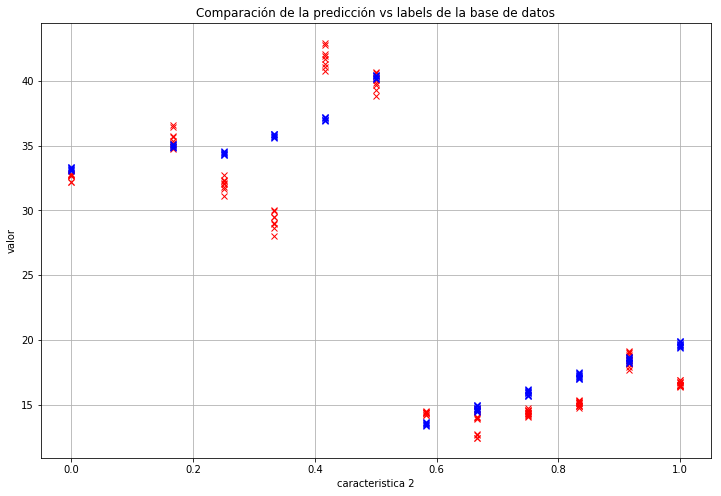

In [35]:
plt.rcParams['figure.figsize'] = (12,8)
plt.grid()
c = 1
plt.plot(X_test[:,c],y_test,'rx')
plt.plot(X_test[:,c],prediction_testing,'bx')
plt.title('Comparación de la predicción vs labels de la base de datos')
plt.xlabel('caracteristica '+ str(c+1))
plt.ylabel('valor')
plt.show()